<a href="https://colab.research.google.com/github/TrynowPht/TPMachineLearning/blob/master/TF_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TRABAJO FINAL**
**MACHINE LEARNING**
2020-2



Integrantes:
*   Piero Herrera
*   Camilo Silva
*   Diego Urrutia


## Caso de Estudio – Diagnosticando de SARS-COV-2


## **Introducción**

El dataset con el que no encontramos es un conjunto de imágenes de tomografía computarizada de SARS-CoV-2 disponible para el público. Este data set contiene 1252 tomografías computarizadas que son positivas para la infección por SARS-CoV-2 (COVID-19) y 1230 tomografías computarizadas para pacientes no infectados por SARS-CoV-2, 2482 Tomografías computarizadas en total. Los datos son reales, basadons en al recopilación de los resultados de pacientes en los hospitales en Sao Paulo, Brasil. Los creadores del data set mencionan que el objetivo de esta data es fomentar la investigación y desarrollo de métodos de IA con el fin de identificar si una persona está infectada po el SARS-COV-2 mediantes el análisis de tomografías computarizadas. El conjunto de datos propuesto está disponible en www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset

Metodología:

1. Descargar dataset con las 2482 tomografías computarizadas
2. Realizar la lectura de la imágenes. (Conversión a numpy.array)
3. Aplicación de *SIFT*, *SURF* y *ORB* para obtener los vectores caracterísitcos de las imágenes del dataset.
4. Uso de *Bag of Words* (BoW) con el fin de reducir cada imagen en un vector característico de esta. Se generará dos dataframes como resultado del uso de BoW en los vectores característicos obtenidos en SIFT, SURF y ORB
5. Estandarizaciós de los datasets de vectores característicos reducidos
6. Aplicación de PCA
7. Se dividirá la data total en una parte de entrenamiento y test. Para la clasificación se han elegido 5 modelos clasificadores: Gaussian Naive Bayes, Multinomial Naive Bayes, Support Vector Machine, Random Forest y Nearest neighbor
4. Aplicados los modelos se realiza la validación correspondiente y la comparación de resultados obtenidos


### Importación de Librerías

Se realiza una instalación de una versión anterior de opencv, debido a que versiones actuales no permiten realizar el computo de keypoints de SIFT y SURF.

In [1]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

  Using cached https://files.pythonhosted.org/packages/61/29/fc60b2de1713aa92946992544329f20ccb5e4ba26290f403e04b7da44105/opencv_contrib_python-3.4.2.17-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/87/86/753182c9085ba4936c0076269a571613387cdb77ae2bf537448bfd63472c/numpy-1.19.4-cp36-cp36m-manylinux2010_x86_64.whl
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.

In [91]:
import time
import random
import os as os
import cv2 as cv
import numpy as np
import pandas as pd
import requests, zipfile, io
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
#Preprocesamiento

from sklearn.preprocessing import StandardScaler


#Clasificadores
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

#Metricas
from sklearn import metrics
from keras.models import Sequential
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score

from yellowbrick.model_selection import ValidationCurve


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Lectura de la data y asignación de clases

Descarga del dataset del link de origen

In [3]:
url = "https://slothnetwork.com/covid.zip"
local_folder = "/content/dataImages"

# Enviando request para obtener el archivo comprimido con las imagenes
response = requests.get(url)

# Extrayendo archivo comprimido en el entorno local
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall(local_folder)

Creación de un diccionario para identificar de mejor manera las clases

In [4]:
lesion_types_pre = {'COVID': 1, 'non-COVID': 0}

Resize de imágenes

In [98]:
cols = ['img', 'class']

# Nuevas medidas para cada una de las imagenes (Resize)
img_width = 320
img_height = 240

df = pd.DataFrame(columns = cols)

# Recorriendo los directorios de las imagenes y generando el dataframe
for target in lesion_types_pre.keys():
  file_path = "/content/dataImages/"+target
  for image_path in os.listdir(file_path):
     image = cv.imread(file_path + "/" + image_path, cv.IMREAD_COLOR)
     image_resize = cv.resize(image, (img_width, img_height))
     df = df.append({'img': image_resize, 'class': lesion_types_pre[target]}, ignore_index=True)

df.groupby('class').count()
y = df['class']

Podemos apreciar la cantidad de imágenes que hay por clase

**Muestra Previa de imagenes y respectiva clase**

<Figure size 432x288 with 0 Axes>

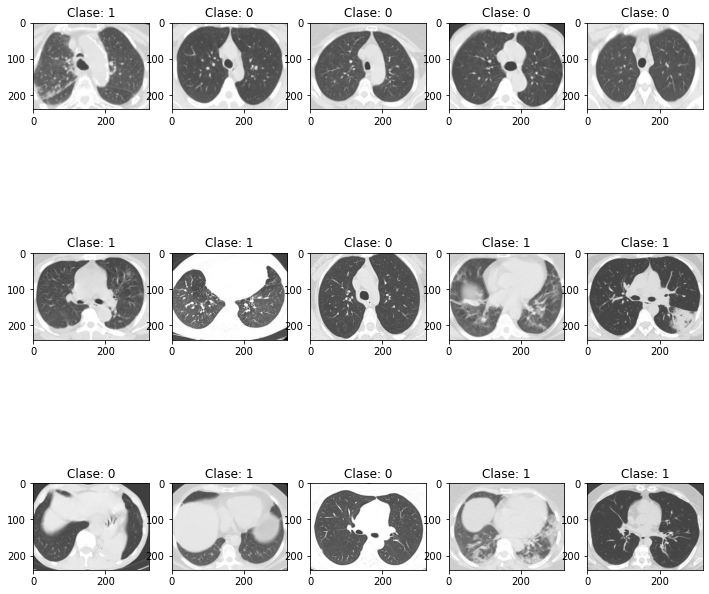

In [6]:
plt.figure()

f, axarr = plt.subplots(3,5, figsize=(12,12)) 

for i in range(0, 3):
  for j in range(0, 5):
    item_index =random.randint(0,df.shape[0])
    axarr[i][j].imshow(df.iloc[item_index]['img'])
    axarr[i][j].set_title("Clase: " + str(df.iloc[item_index]['class']))
plt.show()

#### Aplicación de SIFT

Sift es un algoritmo que permite detectar y describir características locales en imágenes. Para ello se sigue una serie de pasos:
1. **Selección de picos de espacio de escala**: ubicación potencial para encontrar 
entidades.
2. **Localización de puntos clave** : localización precisa de los puntos clave de funciones.
3. **Asignación de orientación**: asignación de orientación a puntos clave.
4. **Descriptor de puntos clave** : describe los puntos clave como un vector.
5. **Coincidencia de puntos clave**

Dimensiones:  (105, 128)


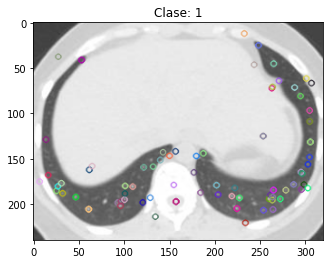

In [7]:
sift = cv.xfeatures2d.SIFT_create()

# Funcion para extraer keypoints con SIFT dado una imagen
def extractKeypointsSift(img):
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  sift_kp, sift_des = sift.detectAndCompute(gray,None)
  return sift_kp, sift_des

random_index = random.randint(0,df.shape[0])
sift_test_img = df.iloc[random_index]['img']
sift_test_class = df.iloc[random_index]['class']

sift_test_keypoints, sift_test_descriptor = extractKeypointsSift(sift_test_img)

gray = cv.cvtColor(sift_test_img, cv.COLOR_BGR2GRAY)
img_sift_kp = cv.drawKeypoints(gray, sift_test_keypoints, None)

print("Dimensiones: ", sift_test_descriptor.shape)
plt.figure()
plt.title("Clase: "+ str(sift_test_class))
plt.imshow(img_sift_kp)
plt.show()

##### Extracción de Keypoints SIFT

In [8]:
start_time_sift = time.time()

# Vectores que almacenan los keypoints y sus descriptores
fSift = []

# Recorriendo cada entrada del dataframe y generando keypoints y descriptores
for i, row in df.iterrows():
  sift_img = extractKeypointsSift(row['img'])
  fSift.append(sift_img)

print("Keypoints SIFT extraidos en %s segundos"  % (time.time() - start_time_sift))

Keypoints SIFT extraidos en 96.57565069198608 segundos


#### Aplicación de SURF

SURF es un algoritmo para la representación y la comparación local de imágenes. De manera similar a otros métetodos también basados en descriptores locales, los *keypoints* de una imagen dada se definen como características sobresalientes de una representación invariante de escala. Dicho análisis se obtiene mediante la convolución de la imagen inicial con granos discretos a varias escalas (filtros de caja) seguido del uso de gradientes locales (intensidad y orientación).

Dimensiones:  (545, 64)


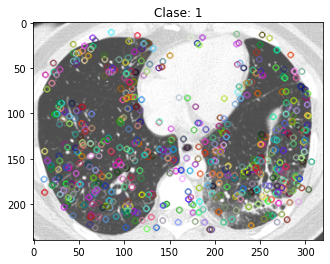

In [9]:
surf = cv.xfeatures2d.SURF_create()

# Funcion para extraer keypoints con SURF dado una imagen
def extractKeypointsSurf(img):
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  surf_kp, surf_des = surf.detectAndCompute(gray,None)
  return surf_kp, surf_des

random_index = random.randint(0,df.shape[0])
surf_test_img = df.iloc[random_index]['img']
surf_test_class = df.iloc[random_index]['class']

surf_test_keypoints, surf_test_descriptor = extractKeypointsSurf(surf_test_img)

gray = cv.cvtColor(surf_test_img, cv.COLOR_BGR2GRAY)
img_surf_kp = cv.drawKeypoints(gray, surf_test_keypoints, None)

print("Dimensiones: ", surf_test_descriptor.shape)
plt.figure()
plt.title("Clase: "+ str(surf_test_class))
plt.imshow(img_surf_kp)
plt.show()

##### Extracción de Keypoints SURF

In [10]:
start_time_surf = time.time()
# Vectores que almacenan los keypoints y sus descriptores
fSurf = []

# Recorriendo cada entrada del dataframe y generando keypoints y descriptores 
for i, row in df.iterrows():
  surf_img = extractKeypointsSurf(row['img'])
  fSurf.append(surf_img)

print("Keypoints SURF extraidos en %s segundos"  % (time.time() - start_time_surf))



Keypoints SURF extraidos en 175.1453263759613 segundos


#### Aplicación de ORB


Dimensiones:  (459, 32)


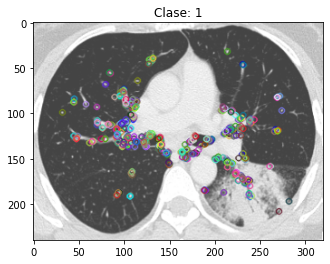

In [11]:
orb = cv.ORB_create()


# Funcion para extraer keypoints con SIFT dado una imagen
def extractKeypointsOrb(img):
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  orb_kp, orb_des = orb.detectAndCompute(gray,None)
  return orb_kp, orb_des

random_index = random.randint(0,df.shape[0])
orb_test_img = df.iloc[random_index]['img']
orb_test_class = df.iloc[random_index]['class']

orb_test_keypoints, orb_test_descriptor = extractKeypointsOrb(orb_test_img)

gray = cv.cvtColor(orb_test_img, cv.COLOR_BGR2GRAY)
img_orb_kp = cv.drawKeypoints(gray, orb_test_keypoints, None)

print("Dimensiones: ", orb_test_descriptor.shape)
plt.figure()
plt.title("Clase: "+ str(orb_test_class))
plt.imshow(img_orb_kp)
plt.show()

##### Extracción de Keypoints ORB

In [12]:
start_time_orb = time.time()

# Vectores que almacenan los keypoints y sus descriptores
fOrb = []

# Recorriendo cada entrada del dataframe y generando keypoints y descriptores
for i, row in df.iterrows():
  orb_img = extractKeypointsOrb(row['img'])
  fOrb.append(orb_img)

print("Keypoints Orb extraidos en %s segundos"  % (time.time() - start_time_orb))



Keypoints Orb extraidos en 11.883888721466064 segundos


### Bag of Words

Modelo para simplificar caraterísticas obtenidas

In [13]:
from sklearn.cluster import MiniBatchKMeans

def applyBow(fFile, df):

  start_time = time.time()

  # Vector que contendrá cada uno de los descriptores
  data = []

  # Recorremos toda la lista de keypoints
  for kp, kp_des in fFile:
    # Recorremos los descriptores de cada imagen
    for kpd in kp_des:
      # Los agregamos al vector
      data.append(kpd)

  # Inicializamos nuestro kmeans, con 50 clusters
  # y un batch size de 6000, y lo entrenamos para agrupar los descriptores
  kmeans = MiniBatchKMeans(n_clusters=20, verbose=0).fit(data)

  kmeans.verbose = False

  # Inicializando un vector que contendrá vectores
  # con cada uno de los histogramas de las imagenes
  features_hist = []
  for kp, kp_des in fFile:
    # Inicializando el histograma que cuantifica las ocurrencias
    # de cada uno de los clusters (50) en cada una de las imagenes
    hist = np.zeros(20)
    for kpd in kp_des:
      # Prediciendo el grupo al que pertenece
      # cada uno de los keypoints
      feature = kmeans.predict([kpd])
      hist[feature] += 1
    # Agregando el histograma de la imagen al
    # vector de histogramas
    features_hist.append(hist)
  
  print("BoW generado en %s segundos"  % (time.time() - start_time))

  # Agregando la clase a cada uno de los 
  # vectores de histograma
  for i, row in df.iterrows():
    features_hist[i] = np.append(features_hist[i], row['class'])

  # Generando un dataframe con los histogramas
  # y la clase de cada imagen como target
  cols = [ 'X'+str(i) for i in range(20) ]
  cols.append('class')

  df_bow = pd.DataFrame(data=features_hist, columns=cols)
  
  return df_bow


### Data Sets de Características resultantes

##### SURF

In [15]:
df_surf= applyBow(fSurf, df)

BoW generado en 547.4048357009888 segundos


In [16]:
df_surf.head(5)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,class
0,36.0,21.0,25.0,29.0,37.0,19.0,103.0,22.0,20.0,16.0,15.0,12.0,1.0,15.0,13.0,26.0,22.0,57.0,27.0,26.0,1.0
1,26.0,16.0,23.0,16.0,21.0,27.0,77.0,20.0,12.0,12.0,12.0,15.0,2.0,17.0,3.0,24.0,2.0,45.0,17.0,23.0,1.0
2,35.0,26.0,19.0,18.0,37.0,32.0,87.0,4.0,13.0,9.0,7.0,13.0,2.0,13.0,17.0,21.0,6.0,59.0,5.0,27.0,1.0
3,5.0,27.0,14.0,1.0,12.0,7.0,75.0,5.0,1.0,6.0,7.0,16.0,0.0,8.0,4.0,5.0,1.0,44.0,7.0,4.0,1.0
4,34.0,57.0,22.0,13.0,59.0,45.0,86.0,13.0,17.0,32.0,4.0,34.0,1.0,25.0,28.0,4.0,24.0,71.0,8.0,11.0,1.0


In [17]:
df_surf.shape

(2481, 21)

##### SIFT

In [18]:
df_sift = applyBow(fSift,df)

BoW generado en 447.23103499412537 segundos


In [19]:
df_sift.head(5)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,class
0,53.0,48.0,22.0,16.0,15.0,17.0,28.0,10.0,5.0,21.0,16.0,32.0,25.0,12.0,12.0,14.0,35.0,19.0,21.0,19.0,1.0
1,68.0,13.0,21.0,40.0,7.0,20.0,26.0,10.0,14.0,24.0,17.0,39.0,16.0,10.0,18.0,16.0,16.0,13.0,24.0,11.0,1.0
2,21.0,43.0,24.0,8.0,27.0,21.0,28.0,13.0,7.0,22.0,17.0,18.0,32.0,21.0,21.0,17.0,41.0,17.0,23.0,25.0,1.0
3,49.0,12.0,8.0,9.0,3.0,8.0,21.0,10.0,7.0,8.0,5.0,9.0,6.0,6.0,4.0,14.0,1.0,5.0,8.0,1.0,1.0
4,7.0,55.0,22.0,9.0,36.0,41.0,74.0,37.0,16.0,29.0,14.0,8.0,40.0,37.0,52.0,16.0,35.0,46.0,9.0,38.0,1.0


In [21]:
df_sift.shape

(2481, 21)

##### ORB

In [22]:
df_orb = applyBow(fOrb,df)

BoW generado en 516.763102054596 segundos


In [23]:
df_orb.head(5)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,class
0,20.0,20.0,32.0,37.0,14.0,17.0,41.0,20.0,13.0,21.0,11.0,27.0,39.0,31.0,17.0,13.0,30.0,20.0,24.0,14.0,1.0
1,24.0,11.0,16.0,18.0,3.0,40.0,23.0,12.0,15.0,24.0,10.0,22.0,26.0,30.0,11.0,15.0,36.0,19.0,49.0,13.0,1.0
2,25.0,24.0,23.0,32.0,21.0,13.0,45.0,15.0,19.0,11.0,8.0,13.0,39.0,5.0,18.0,12.0,27.0,39.0,24.0,30.0,1.0
3,15.0,11.0,13.0,28.0,3.0,10.0,7.0,5.0,6.0,12.0,1.0,8.0,8.0,10.0,15.0,8.0,13.0,17.0,23.0,4.0,1.0
4,12.0,24.0,26.0,29.0,36.0,10.0,42.0,24.0,13.0,7.0,13.0,20.0,16.0,21.0,26.0,21.0,11.0,32.0,11.0,37.0,1.0


In [25]:
df_orb.shape

(2481, 21)

### Dataset de Entrenamiento y Test

Para las pruebas individuales realizamos la división del data frame total. Un 40% de la data sirvió para el entrenamiento y el 60% se usó como test.

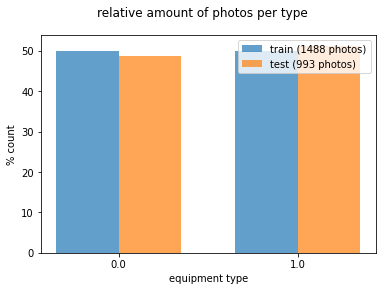

In [30]:
#@title División de la data

X_train, X_test, y_train, y_test = train_test_split(X_Surf, y_Surf, random_state = 10,shuffle=True,test_size = 0.4)

##Esto lo pasamos arriba
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
 
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
 
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
 
    xtemp = np.arange(len(unique))
 
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)),
    'test ({0} photos)'.format(len(y_test))
]);

Surf

In [31]:
X_Surf = df_surf[[x for x in df_surf.columns if x != 'class']]
y_Surf = df_surf['class']

scaler = StandardScaler()
X_Surf = pd.DataFrame(scaler.fit_transform(X_Surf), columns=X_Surf.columns)


#Test
#X_train_Surf, X_test_Surf, y_train_Surf, y_test_Surf = train_test_split(X_Surf, y_Surf, random_state = 10,shuffle=True,test_size = 0.4)

X_Surf

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19
0,0.671815,-0.259570,-0.044357,1.218898,0.730933,-0.613617,0.562334,1.546890,1.637472,-0.393865,0.545432,-0.196772,-0.441858,-0.011821,0.344432,0.541201,2.334457,0.047885,1.140744,0.830949
1,-0.048547,-0.619905,-0.304525,-0.007147,-0.630896,0.159952,-0.292377,1.233406,0.173615,-0.693475,0.111755,0.122377,0.176793,0.262279,-1.104917,0.348586,-1.244145,-0.567409,0.201731,0.526656
2,0.599779,0.100766,-0.824861,0.181476,0.730933,0.643433,0.036358,-1.274471,0.356598,-0.918182,-0.611041,-0.090389,0.176793,-0.285921,0.924172,0.059663,-0.528424,0.150434,-0.925085,0.932380
3,-1.561307,0.172833,-1.475280,-1.421813,-1.396925,-1.773972,-0.358124,-1.117729,-1.839188,-1.142890,-0.611041,0.228760,-1.060509,-0.971172,-0.959982,-1.481258,-1.423075,-0.618684,-0.737283,-1.400532
4,0.527743,2.334848,-0.434609,-0.290080,2.603448,1.900483,0.003485,0.136210,1.088526,0.804576,-1.044718,2.143655,-0.441858,1.358679,2.518456,-1.577566,2.692317,0.765729,-0.643381,-0.690515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2476,1.104032,-0.836107,-1.215112,-0.478702,-1.141582,-0.130136,-0.193756,0.136210,-0.009367,-0.843280,-0.032804,0.122377,0.795444,-0.011821,0.054562,0.059663,0.008366,-0.311037,-0.267776,0.222363
2477,-1.129090,0.965572,-0.824861,-0.950258,-0.886239,-1.000402,-0.292377,-0.960986,-1.656206,-1.142890,-0.900159,-0.090389,-0.441858,-0.422971,-0.235307,-0.518182,-0.707354,1.124650,-0.643381,-0.893377
2478,-0.624836,-0.764040,1.126397,0.653031,-1.141582,-1.000402,0.069232,-0.177275,0.173615,-0.019352,0.256314,-0.515921,-1.060509,-1.245272,-0.815047,-0.036644,0.187296,-0.516135,1.140744,-0.183361
2479,1.752358,-1.196442,0.736146,0.747342,-0.035096,0.546737,0.759575,0.136210,-0.924277,-0.843280,-0.466481,-0.835070,0.795444,-0.148871,-0.670112,1.407970,1.081946,0.201709,0.577336,0.729518


In [32]:
from sklearn.decomposition import PCA
n_components = 10
pca = PCA(n_components)

X_Surf_PCA = pca.fit_transform(X_Surf)

X_Surf_PCA = pd.DataFrame(data = X_Surf_PCA
             , columns = [i+1 for i in range(n_components)])

finalDf = pd.concat([X_Surf_PCA, df_surf[['class']]], axis = 1)

X_train_Surf, X_test_Surf, y_train_Surf, y_test_Surf = train_test_split(X_Surf_PCA, y_Surf, random_state = 10,shuffle=True,test_size = 0.2)

finalDf

,1,2,3,4,5,6,7,8,9,10,class
0,-1.918246,2.048490,0.282730,-0.275925,-0.518844,-0.404518,1.181529,-0.249518,1.177309,1.097221,1.0
1,-1.065742,-0.806630,-0.674960,-0.682065,1.265621,-0.259608,-0.578716,0.711877,-0.125655,-0.340043,1.0
2,0.807722,0.283892,-1.205190,0.400065,0.674922,-0.492555,-0.080008,-0.268475,0.016751,0.890077,1.0
3,2.026151,-4.362657,1.056736,1.122950,1.004911,-0.905655,0.189169,-0.117078,-0.378858,-0.391454,1.0
4,3.924791,4.790344,0.411047,0.558163,-0.675644,-0.398626,0.268141,0.152590,0.376124,0.155264,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2476,0.002096,-0.787554,-1.446781,-0.068497,0.928242,0.034538,1.118838,0.329726,0.315019,0.610586,0.0
2477,1.844037,-2.427265,0.390526,2.060105,0.334863,-0.088346,-0.391649,0.081045,0.365098,-0.259073,0.0
2478,-1.673126,-1.634852,1.369545,-0.356345,-1.264073,-0.286602,0.264260,0.195297,-0.188163,0.214995,0.0
2479,-2.004008,0.181445,-2.283201,0.150078,-0.844920,0.354164,0.194761,-0.052806,1.055492,-0.269037,0.0


shape of X_pca (2481, 11)
[0.31481831 0.21925606 0.07949294 0.05845946 0.04753337 0.04374173
 0.03727326 0.02580159 0.02337656 0.02219349]
suma: 0.8719467735516251


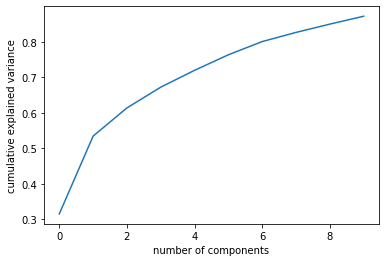

In [34]:
print("shape of X_pca", finalDf.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:10]))
#Vemos que con 5 componentes tenemos algo mas del 75% de varianza explicada
 
#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(expl))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Sift

In [37]:
X_Sift = df_sift[[x for x in df_sift.columns if x != 'class']]
y_Sift = df_sift['class']

scaler = StandardScaler()


X_Sift = pd.DataFrame(scaler.fit_transform(X_Sift), columns=X_Sift.columns)


X_Sift_PCA = pca.fit_transform(X_Sift)

X_Sift_PCA = pd.DataFrame(data = X_Sift_PCA
             , columns = [i+1 for i in range(n_components)])

finalDf_sift = pd.concat([X_Sift_PCA, df_sift[['class']]], axis = 1)



X_train_Sift, X_test_Sift, y_train_Sift, y_test_Sift = train_test_split(X_Sift_PCA, y_Sift, random_state = 42,shuffle=True,test_size = 0.2)

Orb

In [38]:
X_Orb = df_orb [[x for x in df_orb.columns if x != 'class']]
y_Orb = df_orb['class']

scaler = StandardScaler()


X_Orb = pd.DataFrame(scaler.fit_transform(X_Orb), columns = X_Orb.columns)

X_Orb_PCA = pca.fit_transform(X_Orb)

X_Orb_PCA = pd.DataFrame(data = X_Orb_PCA
             , columns = [i+1 for i in range(n_components)])

finalDf_orb = pd.concat([X_Orb_PCA, df_orb[['class']]], axis = 1)

X_train_Orb, X_test_Orb, y_train_Orb, y_test_Orb = train_test_split(X_Orb_PCA, y_Orb, random_state = 10,shuffle=True, test_size = 0.2)

**KFold**

En este caso usamos un numero de divisiones igual a 15 y activamos el parametro random_state para que estas divisiones sean aleatorias.

In [39]:
kfold = KFold(n_splits = 15, random_state = 10, shuffle= True)

### Modelos de Clasificación

Como mencionamos anteriormente, se eligieron 5 modelos de clasificación con el fin de encontrar el que nos devolvía mejores resultado en relación al **accuracy**

In [40]:
#@title ##### Función plot Matriz Gráfica
def showconfusionamtrix(cm):
  plt.matshow(cm)
  plt.colorbar()
  plt.show()

#### **Support Vector Machine (SVM)**

Es un modelo de **aprendizaje supervisado** que analizan los datos utilizados para realizar tanto clasificaciones como regresiones.

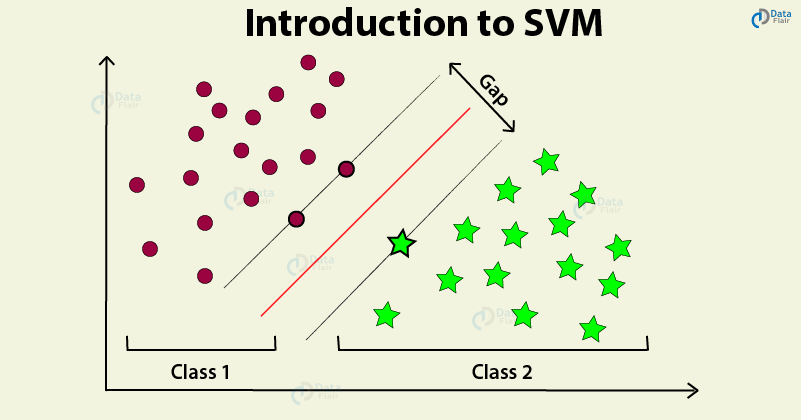

##### SURF

              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86       249
         1.0       0.89      0.80      0.84       248

    accuracy                           0.85       497
   macro avg       0.86      0.85      0.85       497
weighted avg       0.85      0.85      0.85       497

Accuracy Calculado: 0.8511066398390342
F1 Calculado 0.8506822320964932
Precision Calculado 0.8918918918918919
Recall Calculado 0.7983870967741935
Accuracy CrossValidation: 0.8452281854691494 

MATRIZ DE CONFUSIÓN



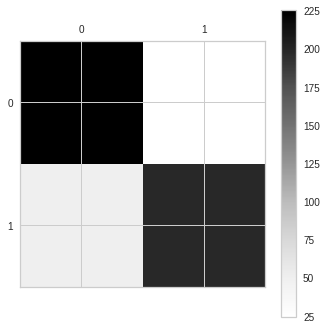

,0,1
0,225,24
1,50,198


In [146]:
SVM_Surf = svm.SVC(kernel='rbf') 

SVM_Surf.fit(X_train_Surf, y_train_Surf)

y_pred_Surf_SVM = SVM_Surf.predict(X_test_Surf)

print(metrics.classification_report(y_test_Surf, y_pred_Surf_SVM,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Surf, y_pred_Surf_SVM))
print("F1 Calculado", metrics.f1_score(y_test_Surf, y_pred_Surf_SVM,average= 'weighted'))
print("Precision Calculado", metrics.precision_score(y_test_Surf, y_pred_Surf_SVM))
print("Recall Calculado", metrics.recall_score(y_test_Surf, y_pred_Surf_SVM))
print("Accuracy CrossValidation:", cross_val_score(SVM_Surf, X_Surf, y_Surf, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SURF_SVM = confusion_matrix(y_test_Surf,y_pred_Surf_SVM)
DF_CM_SURF_SVM = pd.DataFrame(data = CM_SURF_SVM)

print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SURF_SVM)
DF_CM_SURF_SVM


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Text(0, 0.5, 'Accuracy')

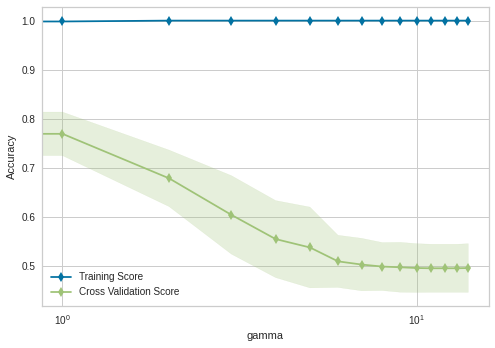

In [106]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
param_range = np.arange(0, 15, 1)


svcSurfv = ValidationCurve(
    SVC(), param_name="gamma", param_range=param_range,
    logx=True, cv=kfold, scoring="accuracy", n_jobs=4,
)

svcSurfv.fit(X_train_Surf, y_train_Surf)
plt.legend(loc='best')
plt.xlabel('gamma')
plt.ylabel('Accuracy')

##### SIFT

              precision    recall  f1-score   support

         0.0       0.83      0.90      0.87       258
         1.0       0.88      0.80      0.84       239

    accuracy                           0.86       497
   macro avg       0.86      0.85      0.85       497
weighted avg       0.86      0.86      0.85       497

Accuracy Calculado: 0.8551307847082495
F1 Calculado 0.8545981425630678
Precision Calculado 0.8847926267281107
Recall Calculado 0.803347280334728
Accuracy CrossValidation: 0.8581453085067542 

MATRIZ DE CONFUSIÓN



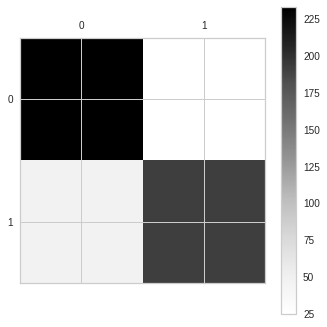

,0,1
0,233,25
1,47,192


In [147]:
SVM_Sift = svm.SVC(kernel='rbf') 

SVM_Sift.fit(X_train_Sift, y_train_Sift)

y_pred_Sift_SVM = SVM_Sift.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_SVM,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Sift, y_pred_Sift_SVM))
print("F1 Calculado", metrics.f1_score(y_test_Sift, y_pred_Sift_SVM,average= 'weighted'))
print("Precision Calculado", metrics.precision_score(y_test_Sift, y_pred_Sift_SVM))
print("Recall Calculado", metrics.recall_score(y_test_Sift, y_pred_Sift_SVM))
print("Accuracy CrossValidation:", cross_val_score(SVM_Sift, X_Sift, y_Sift, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SIFT_SVM = confusion_matrix(y_test_Sift,y_pred_Sift_SVM)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_SVM)
DF_CM_SIFT_SVM = pd.DataFrame(data = CM_SIFT_SVM)
DF_CM_SIFT_SVM

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Text(0, 0.5, 'Accuracy')

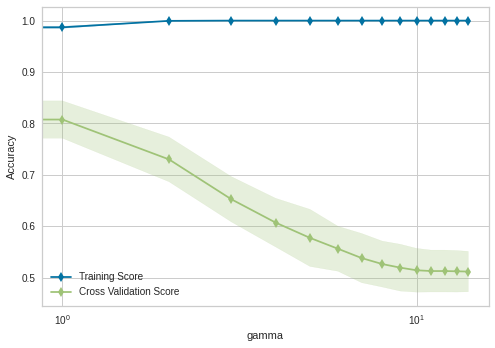

In [113]:
param_range = np.arange(0, 15, 1)


svcSiftv = ValidationCurve(
    SVC(), param_name="gamma", param_range=param_range,
    logx=True, cv=kfold, scoring="accuracy", n_jobs=4,
)

svcSiftv.fit(X_train_Sift, y_train_Sift)
plt.legend(loc='best')
plt.xlabel('gamma')
plt.ylabel('Accuracy')

#####ORB

              precision    recall  f1-score   support

         0.0       0.64      0.80      0.71       249
         1.0       0.73      0.55      0.63       248

    accuracy                           0.67       497
   macro avg       0.68      0.67      0.67       497
weighted avg       0.68      0.67      0.67       497

Accuracy Calculado: 0.6720321931589537
F1 Calculado 0.6669312360085708
Precision Calculado 0.7272727272727273
Recall Calculado 0.5483870967741935
Accuracy CrossValidation: 0.7066033832298892 

MATRIZ DE CONFUSIÓN



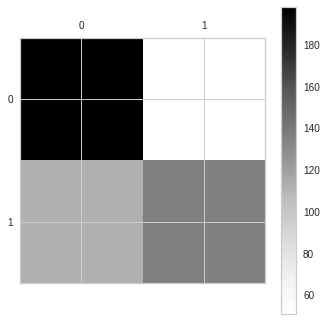

,0,1
0,198,51
1,112,136


In [148]:
SVM_Orb = svm.SVC(kernel = 'rbf')

SVM_Orb.fit(X_train_Orb, y_train_Orb)

y_pred_Orb_SVM = SVM_Orb.predict(X_test_Orb)

print(metrics.classification_report(y_test_Orb, y_pred_Orb_SVM, zero_division = 0))

print("Accuracy Calculado:", metrics.accuracy_score(y_test_Orb, y_pred_Orb_SVM))
print("F1 Calculado", metrics.f1_score(y_test_Orb, y_pred_Orb_SVM,average= 'weighted'))
print("Precision Calculado", metrics.precision_score(y_test_Orb, y_pred_Orb_SVM))
print("Recall Calculado", metrics.recall_score(y_test_Orb, y_pred_Orb_SVM))
print("Accuracy CrossValidation:", cross_val_score(SVM_Orb, X_Orb, y_Orb, cv = kfold, scoring = "accuracy").mean(), "\n")

CM_ORB_SVM = confusion_matrix(y_test_Orb, y_pred_Orb_SVM)
DF_CM_ORB_SVM = pd.DataFrame(data = CM_ORB_SVM)

print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_ORB_SVM)
DF_CM_ORB_SVM

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Text(0, 0.5, 'Accuracy')

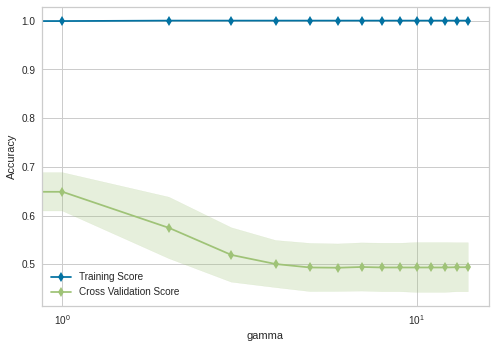

In [115]:
param_range = np.arange(0, 15, 1)


svcOrbv = ValidationCurve(
    SVC(), param_name="gamma", param_range=param_range,
    logx=True, cv=kfold, scoring="accuracy", n_jobs=4,
)

svcOrbv.fit(X_train_Orb, y_train_Orb)
plt.legend(loc='best')
plt.xlabel('gamma')
plt.ylabel('Accuracy')

#### **Random Forest** 

Es un algoritmo de clasificación que está basado en árboles de decisiones. Construye de manera aleatoria cada árbol individual para tratar de crear un bosque de árboles no correlacionado cuya predicción es más precisa que la de cualquier árbol individual. 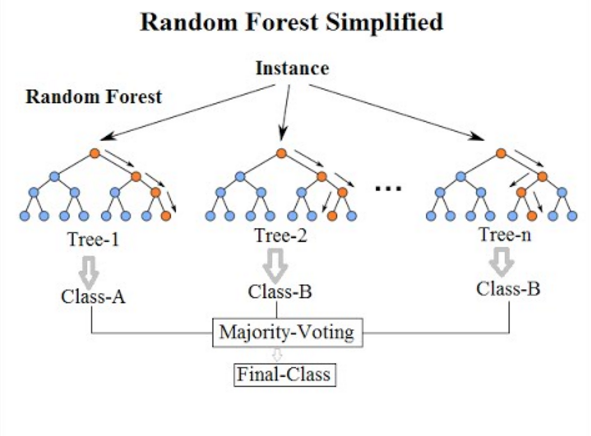

##### SURF

              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80       249
         1.0       0.82      0.73      0.77       248

    accuracy                           0.78       497
   macro avg       0.79      0.78      0.78       497
weighted avg       0.79      0.78      0.78       497

Accuracy Calculado: 0.7847082494969819
F1 Calculado 0.7839471890605995
Precision Calculado 0.821917808219178
Recall Calculado 0.7258064516129032
Accuracy CrossValidation: 0.8024777899476694 

MATRIZ DE CONFUSIÓN



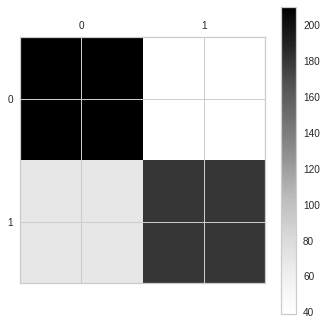

,0,1
0,210,39
1,68,180


In [149]:
RF_Surf = RandomForestClassifier(max_depth=3, random_state=10)
RF_Surf.fit(X_train_Surf, y_train_Surf)

y_pred_Surf_RF = RF_Surf.predict(X_test_Surf)

print(metrics.classification_report(y_test_Surf, y_pred_Surf_RF,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Surf, y_pred_Surf_RF))
print("F1 Calculado", metrics.f1_score(y_test_Surf, y_pred_Surf_RF,average= 'weighted'))
print("Precision Calculado", metrics.precision_score(y_test_Surf, y_pred_Surf_RF))
print("Recall Calculado", metrics.recall_score(y_test_Surf, y_pred_Surf_RF))
print("Accuracy CrossValidation:", cross_val_score(RF_Surf, X_Surf, y_Surf, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SURF_RF = confusion_matrix(y_test_Surf,y_pred_Surf_RF)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SURF_RF)
DF_CM_SURF_RF = pd.DataFrame(data = CM_SURF_RF)
DF_CM_SURF_RF

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


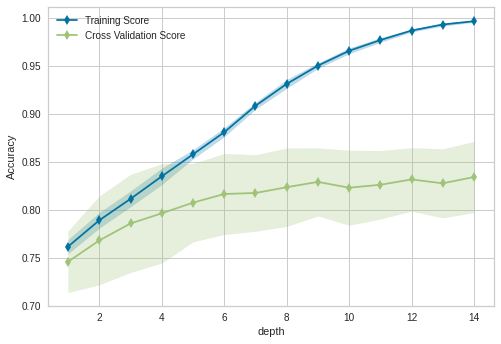

In [109]:
clfVcF1w = ValidationCurve(
    RandomForestClassifier(), param_name="max_depth",
    param_range=param_range, cv=kfold, scoring="accuracy", n_jobs=4,
)
clfVcF1w.fit(X_train_Surf, y_train_Surf)
plt.legend(loc='best')
plt.xlabel('depth')
plt.ylabel('Accuracy')
plt.show()

##### SIFT

              precision    recall  f1-score   support

         0.0       0.80      0.79      0.80       258
         1.0       0.78      0.79      0.78       239

    accuracy                           0.79       497
   macro avg       0.79      0.79      0.79       497
weighted avg       0.79      0.79      0.79       497

Accuracy Calculado: 0.7907444668008048
F1 Calculado 0.790795342594989
Precision Calculado 0.7777777777777778
Recall Calculado 0.7907949790794979
Accuracy CrossValidation: 0.7976536448825606 

MATRIZ DE CONFUSIÓN



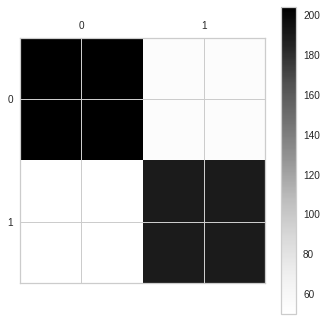

,0,1
0,204,54
1,50,189


In [150]:
RF_Sift = RandomForestClassifier(max_depth=3, random_state=10)
RF_Sift.fit(X_train_Sift, y_train_Sift)

y_pred_Sift_RF = RF_Sift.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_RF,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Sift, y_pred_Sift_RF))
print("F1 Calculado", metrics.f1_score(y_test_Sift, y_pred_Sift_RF,average= 'weighted'))
print("Precision Calculado", metrics.precision_score(y_test_Sift, y_pred_Sift_RF))
print("Recall Calculado", metrics.recall_score(y_test_Sift, y_pred_Sift_RF))
print("Accuracy CrossValidation:", cross_val_score(RF_Sift, X_Sift, y_Sift, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SIFT_RF = confusion_matrix(y_test_Sift,y_pred_Sift_RF)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_RF)
DF_CM_SIFT_RF = pd.DataFrame(data = CM_SIFT_RF)
DF_CM_SIFT_RF

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


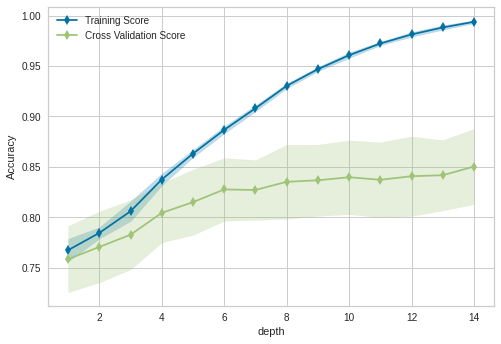

In [110]:
clfVcF1w = ValidationCurve(
    RandomForestClassifier(), param_name="max_depth",
    param_range=param_range, cv=kfold, scoring="accuracy", n_jobs=4,
)
clfVcF1w.fit(X_train_Sift, y_train_Sift)
plt.legend(loc='best')
plt.xlabel('depth')
plt.ylabel('Accuracy')
plt.show()

##### ORB

              precision    recall  f1-score   support

         0.0       0.64      0.86      0.73       249
         1.0       0.79      0.52      0.62       248

    accuracy                           0.69       497
   macro avg       0.71      0.69      0.68       497
weighted avg       0.71      0.69      0.68       497

Accuracy Calculado: 0.6881287726358148
F1 Calculado 0.6786143528337499
Precision Calculado 0.7852760736196319
Recall Calculado 0.5161290322580645
Accuracy CrossValidation: 0.6674917853231107 

MATRIZ DE CONFUSIÓN



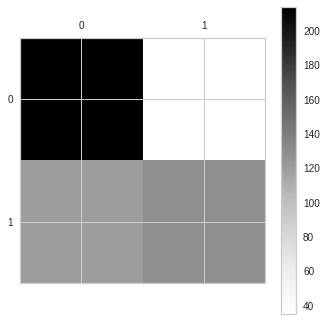

,0,1
0,214,35
1,120,128


In [151]:
RF_Orb = RandomForestClassifier(max_depth=3, random_state=10)
RF_Orb.fit(X_train_Orb, y_train_Orb)

y_pred_Orb_RF = RF_Orb.predict(X_test_Orb)

print(metrics.classification_report(y_test_Orb, y_pred_Orb_RF,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Orb, y_pred_Orb_RF))
print("F1 Calculado", metrics.f1_score(y_test_Orb, y_pred_Orb_RF,average= 'weighted'))
print("Precision Calculado", metrics.precision_score(y_test_Orb, y_pred_Orb_RF))
print("Recall Calculado", metrics.recall_score(y_test_Orb, y_pred_Orb_RF))
print("Accuracy CrossValidation:", cross_val_score(RF_Orb, X_Orb, y_Orb, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_ORB_RF = confusion_matrix(y_test_Orb,y_pred_Orb_RF)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_ORB_RF)
DF_CM_ORB_RF = pd.DataFrame(data = CM_ORB_RF)
DF_CM_ORB_RF

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


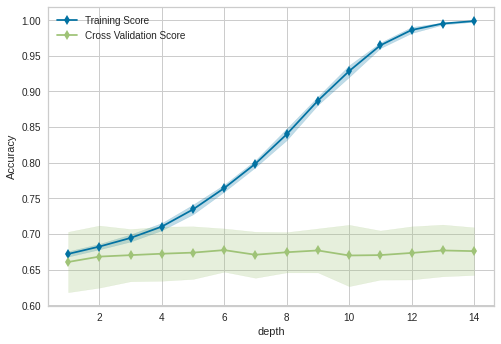

In [111]:
clfVcF1w = ValidationCurve(
    RandomForestClassifier(), param_name="max_depth",
    param_range=param_range, cv=kfold, scoring="accuracy", n_jobs=4,
)
clfVcF1w.fit(X_train_Orb, y_train_Orb)
plt.legend(loc='best')
plt.xlabel('depth')
plt.ylabel('Accuracy')
plt.show()

#### **KNeighborsClassifier**

El principio detrás este modelo es encontrar un número predefinido de muestras de entrenamiento más cercanas en distancia al nuevo punto y de esta forma la la clase a partir de ellas. El valor de ***n*** nos indica la cantidad de vecinos que tomaremos en cuenta para la clasificación y la complejidad. 

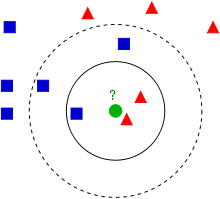

##### SURF

              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       249
         1.0       0.88      0.80      0.84       248

    accuracy                           0.85       497
   macro avg       0.85      0.85      0.85       497
weighted avg       0.85      0.85      0.85       497

Accuracy Calculado: 0.8470824949698189
F1 Calculado 0.8467685698742927
Precision Calculado 0.8805309734513275
Recall Calculado 0.8024193548387096
Accuracy CrossValidation: 0.8432079834489472 

MATRIZ DE CONFUSIÓN



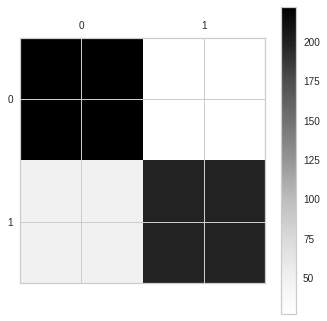

,0,1
0,222,27
1,49,199


In [152]:
KNN_Surf = KNeighborsClassifier(n_neighbors=15)

KNN_Surf.fit(X_train_Surf, y_train_Surf)

y_pred_Surf_KNN = KNN_Surf.predict(X_test_Surf)

print(metrics.classification_report(y_test_Surf, y_pred_Surf_KNN,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Surf, y_pred_Surf_KNN))
print("F1 Calculado", metrics.f1_score(y_test_Surf, y_pred_Surf_KNN,average= 'weighted'))
print("Precision Calculado", metrics.precision_score(y_test_Surf, y_pred_Surf_KNN))
print("Recall Calculado", metrics.recall_score(y_test_Surf, y_pred_Surf_KNN))
print("Accuracy CrossValidation:", cross_val_score(KNN_Surf, X_Surf, y_Surf, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SURF_KNN = confusion_matrix(y_test_Surf,y_pred_Surf_KNN)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SURF_KNN)
DF_CM_SURF_KNN = pd.DataFrame(data = CM_SURF_KNN)
DF_CM_SURF_KNN

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


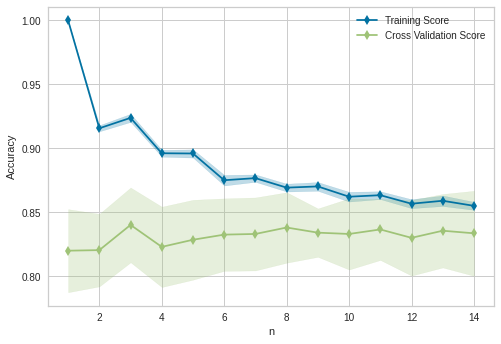

In [116]:
knnSurfv = ValidationCurve(
    KNeighborsClassifier(), param_name="n_neighbors",
    param_range=param_range, cv=kfold, scoring="accuracy", n_jobs=4,
)
knnSurfv.fit(X_train_Surf, y_train_Surf)
plt.legend(loc='best')
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.show()

##### SIFT

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       258
         1.0       0.86      0.79      0.83       239

    accuracy                           0.84       497
   macro avg       0.84      0.84      0.84       497
weighted avg       0.84      0.84      0.84       497

Accuracy Calculado: 0.8410462776659959
F1 Calculado 0.8405789285424436
Precision Calculado 0.8636363636363636
Recall Calculado 0.7949790794979079
Accuracy CrossValidation: 0.8581355725934041 

MATRIZ DE CONFUSIÓN



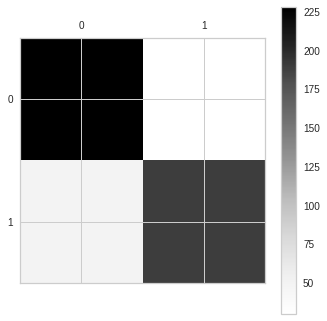

,0,1
0,228,30
1,49,190


In [155]:
KNN_Sift = KNeighborsClassifier(n_neighbors=15)

KNN_Sift.fit(X_train_Sift, y_train_Sift)

y_pred_Sift_KNN = KNN_Sift.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_KNN,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Sift, y_pred_Sift_KNN))
print("F1 Calculado", metrics.f1_score(y_test_Sift, y_pred_Sift_KNN,average= 'weighted'))
print("Precision Calculado", metrics.precision_score(y_test_Sift, y_pred_Sift_KNN))
print("Recall Calculado", metrics.recall_score(y_test_Sift, y_pred_Sift_KNN))
print("Accuracy CrossValidation:", cross_val_score(KNN_Sift, X_Sift, y_Sift, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SIFT_KNN = confusion_matrix(y_test_Sift,y_pred_Sift_KNN)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_KNN)
DF_CM_SIFT_KNN = pd.DataFrame(data = CM_SIFT_KNN)
DF_CM_SIFT_KNN

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


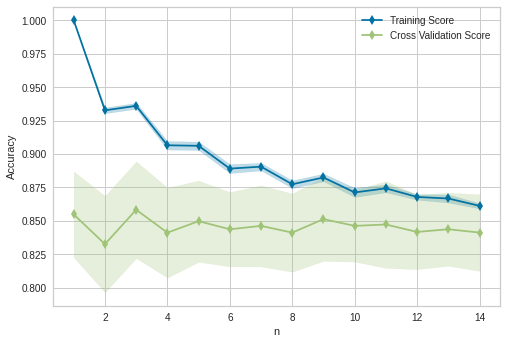

In [118]:
knnSiftv = ValidationCurve(
    KNeighborsClassifier(), param_name="n_neighbors",
    param_range=param_range, cv=kfold, scoring="accuracy", n_jobs=4,
)
knnSiftv.fit(X_train_Sift, y_train_Sift)
plt.legend(loc='best')
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.show()

##### ORB

              precision    recall  f1-score   support

         0.0       0.65      0.73      0.69       249
         1.0       0.70      0.61      0.65       248

    accuracy                           0.67       497
   macro avg       0.67      0.67      0.67       497
weighted avg       0.67      0.67      0.67       497

Accuracy Calculado: 0.6720321931589537
F1 Calculado 0.6707095756644468
Precision Calculado 0.695852534562212
Recall Calculado 0.6088709677419355
Accuracy CrossValidation: 0.6876548618717294 

MATRIZ DE CONFUSIÓN



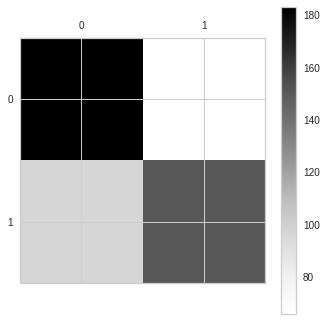

,0,1
0,183,66
1,97,151


In [156]:
KNN_Orb = KNeighborsClassifier(n_neighbors=15)

KNN_Orb.fit(X_train_Orb, y_train_Orb)

y_pred_Orb_KNN = KNN_Orb.predict(X_test_Orb)

print(metrics.classification_report(y_test_Orb, y_pred_Orb_KNN,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Orb, y_pred_Orb_KNN))
print("F1 Calculado", metrics.f1_score(y_test_Orb, y_pred_Orb_KNN,average= 'weighted'))
print("Precision Calculado", metrics.precision_score(y_test_Orb, y_pred_Orb_KNN))
print("Recall Calculado", metrics.recall_score(y_test_Orb, y_pred_Orb_KNN))
print("Accuracy CrossValidation:", cross_val_score(KNN_Orb, X_Orb, y_Orb, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_ORB_KNN = confusion_matrix(y_test_Orb,y_pred_Orb_KNN)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_ORB_KNN)
DF_CM_ORB_KNN = pd.DataFrame(data = CM_ORB_KNN)
DF_CM_ORB_KNN

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


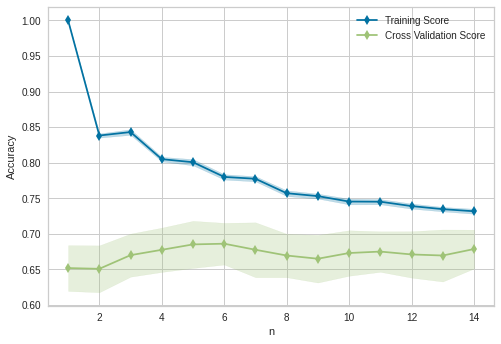

In [119]:
knnOrbv = ValidationCurve(
    KNeighborsClassifier(), param_name="n_neighbors",
    param_range=param_range, cv=kfold, scoring="accuracy", n_jobs=4,
)
knnOrbv.fit(X_train_Orb, y_train_Orb)
plt.legend(loc='best')
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.show()

#### **Gaussian Naive Bayes**

Modelo basado en una distribución continua y que se adecúa de mejor manera para tareas de clasificación más genéricas.

##### SURF

              precision    recall  f1-score   support

         0.0       0.73      0.87      0.79       249
         1.0       0.84      0.67      0.75       248

    accuracy                           0.77       497
   macro avg       0.78      0.77      0.77       497
weighted avg       0.78      0.77      0.77       497

Accuracy Calculado: 0.772635814889336
F1 Calculado 0.7703576073242928
Precision Calculado 0.8391959798994975
Recall Calculado 0.6733870967741935
Accuracy CrossValidation: 0.7944334915419252 

MATRIZ DE CONFUSIÓN



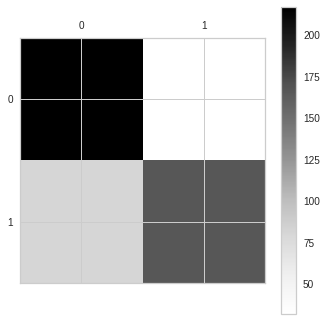

,0,1
0,217,32
1,81,167


In [157]:
GNB_Surf = GaussianNB()

GNB_Surf.fit(X_train_Surf, y_train_Surf)

y_pred_Surf_GNB = GNB_Surf.predict(X_test_Surf)

print(metrics.classification_report(y_test_Surf, y_pred_Surf_GNB,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Surf, y_pred_Surf_GNB))
print("F1 Calculado", metrics.f1_score(y_test_Surf, y_pred_Surf_GNB,average= 'weighted'))
print("Precision Calculado", metrics.precision_score(y_test_Surf, y_pred_Surf_GNB))
print("Recall Calculado", metrics.recall_score(y_test_Surf, y_pred_Surf_GNB))
print("Accuracy CrossValidation:", cross_val_score(GNB_Surf, X_Surf, y_Surf, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SURF_GNB = confusion_matrix(y_test_Surf,y_pred_Surf_GNB)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SURF_GNB)
DF_CM_SURF_GNB = pd.DataFrame(data = CM_SURF_GNB)
DF_CM_SURF_GNB

##### SIFT

              precision    recall  f1-score   support

         0.0       0.78      0.83      0.80       258
         1.0       0.80      0.74      0.77       239

    accuracy                           0.79       497
   macro avg       0.79      0.79      0.79       497
weighted avg       0.79      0.79      0.79       497

Accuracy Calculado: 0.7867203219315896
F1 Calculado 0.7862343805370385
Precision Calculado 0.7982062780269058
Recall Calculado 0.7447698744769874
Accuracy CrossValidation: 0.7787051235244006 

MATRIZ DE CONFUSIÓN



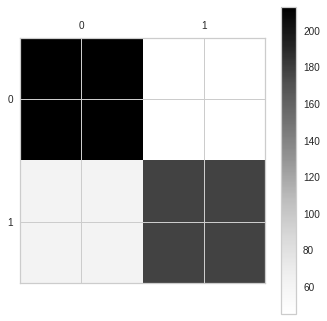

,0,1
0,213,45
1,61,178


In [158]:
GNB_Sift = GaussianNB()

GNB_Sift.fit(X_train_Sift, y_train_Sift)

y_pred_Sift_GNB = GNB_Sift.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_GNB,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Sift, y_pred_Sift_GNB))
print("F1 Calculado", metrics.f1_score(y_test_Sift, y_pred_Sift_GNB,average= 'weighted'))
print("Precision Calculado", metrics.precision_score(y_test_Sift, y_pred_Sift_GNB))
print("Recall Calculado", metrics.recall_score(y_test_Sift, y_pred_Sift_GNB))
print("Accuracy CrossValidation:", cross_val_score(GNB_Sift, X_Sift, y_Sift, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SIFT_GNB = confusion_matrix(y_test_Sift,y_pred_Sift_GNB)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_GNB)
DF_CM_SIFT_GNB = pd.DataFrame(data = CM_SIFT_GNB)
DF_CM_SIFT_GNB

##### ORB

              precision    recall  f1-score   support

         0.0       0.65      0.80      0.72       249
         1.0       0.74      0.57      0.64       248

    accuracy                           0.68       497
   macro avg       0.69      0.68      0.68       497
weighted avg       0.69      0.68      0.68       497

Accuracy Calculado: 0.6841046277665996
F1 Calculado 0.6798182681014984
Precision Calculado 0.7382198952879581
Recall Calculado 0.5685483870967742
Accuracy CrossValidation: 0.6630497748570038 

MATRIZ DE CONFUSIÓN



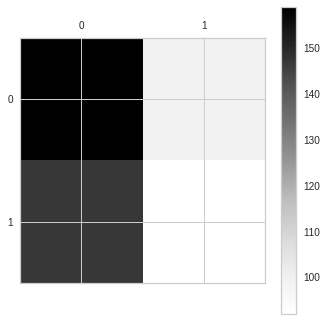

,0,1
0,159,99
1,147,92


In [159]:
GNB_Orb = GaussianNB()

GNB_Orb.fit(X_train_Orb, y_train_Orb)

y_pred_Orb_GNB = GNB_Orb.predict(X_test_Orb)

print(metrics.classification_report(y_test_Orb, y_pred_Orb_GNB, zero_division = 0))

print("Accuracy Calculado:", metrics.accuracy_score(y_test_Orb, y_pred_Orb_GNB))
print("F1 Calculado", metrics.f1_score(y_test_Orb, y_pred_Orb_GNB,average= 'weighted'))
print("Precision Calculado", metrics.precision_score(y_test_Orb, y_pred_Orb_GNB))
print("Recall Calculado", metrics.recall_score(y_test_Orb, y_pred_Orb_GNB))
print("Accuracy CrossValidation:", cross_val_score(GNB_Orb, X_Orb, y_Orb, cv = kfold, scoring = "accuracy").mean(),"\n")

CM_ORB_GNB = confusion_matrix(y_test_Sift,y_pred_Orb_GNB)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_ORB_GNB)
DF_CM_ORB_GNB = pd.DataFrame(data = CM_ORB_GNB)
DF_CM_ORB_GNB

#### **VotingClassifier**


##### SURF

              precision    recall  f1-score   support

         0.0       0.81      0.91      0.85       249
         1.0       0.89      0.78      0.83       248

    accuracy                           0.85       497
   macro avg       0.85      0.84      0.84       497
weighted avg       0.85      0.85      0.84       497

Accuracy Calculado: 0.8450704225352113
F1 Calculado 0.8444456277678676
Precision Calculado 0.8940092165898618
Recall Calculado 0.782258064516129
Accuracy CrossValidation: 0.8375781915540952 

MATRIZ DE CONFUSIÓN



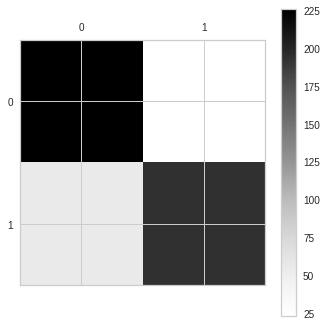

,0,1
0,226,23
1,54,194


In [160]:
estimadores = []
estimadores.append(("Naive Bayes", GaussianNB()))
estimadores.append(("Random Forest", RandomForestClassifier()))
estimadores.append(("SVM",svm.SVC()))


Voting_Surf = VotingClassifier(estimadores)

Voting_Surf.fit(X_train_Surf,y_train_Surf)

y_pred_Surf_Voting = Voting_Surf.predict(X_test_Surf)

print(metrics.classification_report(y_test_Surf, y_pred_Surf_Voting,zero_division=0))
print("Accuracy Calculado:",metrics.accuracy_score(y_test_Surf, y_pred_Surf_Voting))
print("F1 Calculado", metrics.f1_score(y_test_Surf, y_pred_Surf_Voting,average= 'weighted'))
print("Precision Calculado", metrics.precision_score(y_test_Surf, y_pred_Surf_Voting))
print("Recall Calculado", metrics.recall_score(y_test_Surf, y_pred_Surf_Voting))
print("Accuracy CrossValidation:", cross_val_score(Voting_Surf, X_Surf, y_Surf, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SURF_VOTING = confusion_matrix(y_test_Surf, y_pred_Surf_Voting)

print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SURF_VOTING)

DF_CM_SURF_VOTING = pd.DataFrame(data = CM_SURF_VOTING)
DF_CM_SURF_VOTING

##### SIFT

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       258
         1.0       0.86      0.79      0.83       239

    accuracy                           0.84       497
   macro avg       0.84      0.84      0.84       497
weighted avg       0.84      0.84      0.84       497

Accuracy Calculado: 0.8390342052313883
F1 Calculado 0.83859778111758
Precision Calculado 0.8597285067873304
Recall Calculado 0.7949790794979079
Accuracy CrossValidation: 0.8557283680175245 

MATRIZ DE CONFUSIÓN



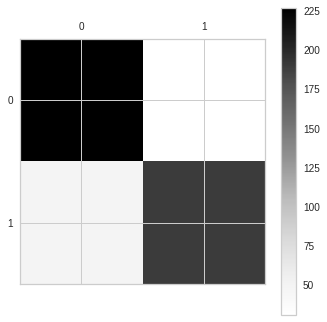

,0,1
0,227,31
1,49,190


In [161]:


Voting_Sift = VotingClassifier(estimadores)

Voting_Sift.fit(X_train_Sift, y_train_Sift)

y_pred_Sift_Voting = Voting_Sift.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_Voting, zero_division = 0))
print("Accuracy Calculado:", metrics.accuracy_score(y_test_Sift, y_pred_Sift_Voting))
print("F1 Calculado", metrics.f1_score(y_test_Sift, y_pred_Sift_Voting,average= 'weighted'))
print("Precision Calculado", metrics.precision_score(y_test_Sift, y_pred_Sift_Voting))
print("Recall Calculado", metrics.recall_score(y_test_Sift, y_pred_Sift_Voting))
print("Accuracy CrossValidation:", cross_val_score(Voting_Sift, X_Sift, y_Sift, cv = kfold, scoring = "accuracy").mean(), "\n")

CM_SIFT_VOTING = confusion_matrix(y_test_Sift, y_pred_Sift_Voting)

print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_VOTING)

DF_CM_SIFT_VOTING = pd.DataFrame(data = CM_SIFT_VOTING)
DF_CM_SIFT_VOTING



##### ORB

              precision    recall  f1-score   support

         0.0       0.65      0.79      0.71       249
         1.0       0.73      0.57      0.64       248

    accuracy                           0.68       497
   macro avg       0.69      0.68      0.68       497
weighted avg       0.69      0.68      0.68       497

Accuracy Calculado: 0.682092555331992
F1 Calculado 0.6782226904610824
Precision Calculado 0.7319587628865979
Recall Calculado 0.5725806451612904
Accuracy CrossValidation: 0.7053839600827553 

MATRIZ DE CONFUSIÓN



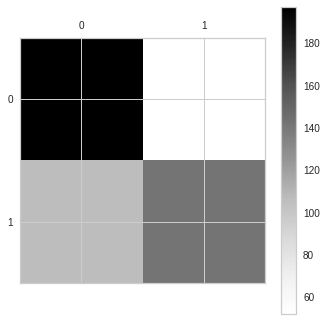

,0,1
0,197,52
1,106,142


In [162]:
Voting_Orb = VotingClassifier(estimadores)

Voting_Orb.fit(X_train_Orb, y_train_Orb)

y_pred_Orb_Voting = Voting_Orb.predict(X_test_Orb)

print(metrics.classification_report(y_test_Orb, y_pred_Orb_Voting, zero_division = 0))
print("Accuracy Calculado:", metrics.accuracy_score(y_test_Orb, y_pred_Orb_Voting))
print("F1 Calculado", metrics.f1_score(y_test_Orb, y_pred_Orb_Voting,average= 'weighted'))
print("Precision Calculado", metrics.precision_score(y_test_Orb, y_pred_Orb_Voting))
print("Recall Calculado", metrics.recall_score(y_test_Orb, y_pred_Orb_Voting))
print("Accuracy CrossValidation:", cross_val_score(Voting_Orb, X_Orb, y_Orb, cv = kfold, scoring = "accuracy").mean(), "\n")

CM_ORB_VOTING = confusion_matrix(y_test_Orb, y_pred_Orb_Voting)

print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_ORB_VOTING)

DF_CM_ORB_VOTING = pd.DataFrame(data = CM_ORB_VOTING)
DF_CM_ORB_VOTING

### Comparación de resultados

Para el análisis realizamos un gráfico de cajas que permitirá visualizar cada modelo.

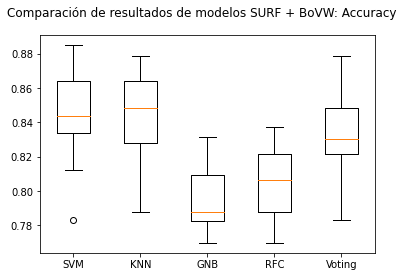

In [60]:
#@title Diagrama de Cajas - SURF
models = []

modelo = Sequential()


models.append(('SVM', SVM_Surf ))
models.append(('KNN', KNN_Surf))
models.append(('GNB', GNB_Surf))
models.append(('RFC', RF_Surf))
models.append(('Voting', Voting_Surf))

results = []
names = []

for name, model in models:
	cv_results = cross_val_score(model, X_Surf, y_Surf, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)


fig = plt.figure()
fig.suptitle('Comparación de resultados de modelos SURF + BoVW: Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

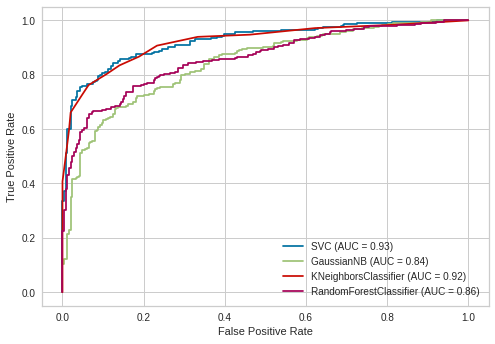

In [138]:
#@title ##### Specificity VS Sensibility- SURF

from sklearn.metrics import plot_roc_curve

svc_plot = plot_roc_curve(SVM_Surf, X_test_Surf, y_test_Surf)
gnb_plot = plot_roc_curve(GNB_Surf, X_test_Surf, y_test_Surf, ax=ax, alpha=1)
ax = plt.gca()

gnb_plot.plot(ax = ax, alpha =1)

knn_plot = plot_roc_curve(KNN_Surf, X_test_Surf, y_test_Surf, ax = ax)

randomforest_plot = plot_roc_curve(RF_Surf,X_test_Surf, y_test_Surf, ax = ax, alpha = 1)


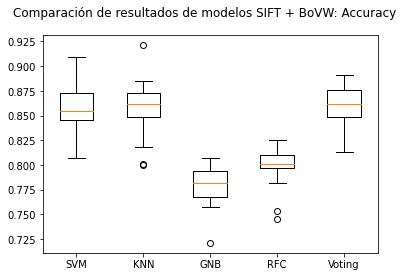

In [59]:
#@title Diagrama de Cajas - SIFT
models = []

modelo = Sequential()


models.append(('SVM', SVM_Sift))
models.append(('KNN', KNN_Sift))
models.append(('GNB', GNB_Sift))
models.append(('RFC', RF_Sift))
models.append(('Voting',Voting_Sift))
results = []
names = []

for name, model in models:
	cv_results = cross_val_score(model, X_Sift, y_Sift, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)


fig = plt.figure()
fig.suptitle('Comparación de resultados de modelos SIFT + BoVW: Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

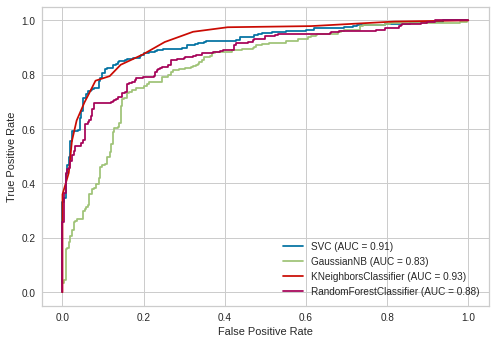

In [139]:
#@title ##### Specificity VS Sensibility- SIFT


svc_plot = plot_roc_curve(SVM_Sift, X_test_Sift, y_test_Sift)
gnb_plot = plot_roc_curve(GNB_Sift, X_test_Sift, y_test_Sift, ax = ax, alpha = 1)
ax = plt.gca()

gnb_plot.plot(ax = ax, alpha = 1)

knn_plot = plot_roc_curve(KNN_Sift, X_test_Sift, y_test_Sift, ax = ax)

randomforest_plot = plot_roc_curve(RF_Sift, X_test_Sift, y_test_Sift, ax = ax, alpha = 1)


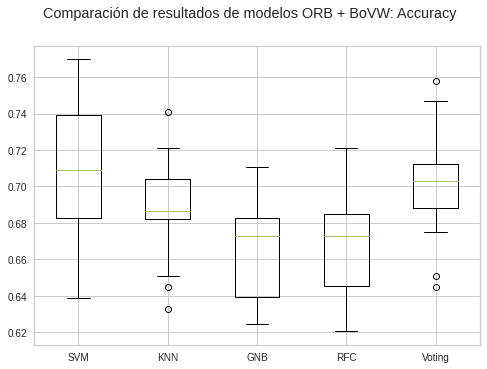

In [132]:
#@title Diagrama de Cajas - ORB
models = []

modelo = Sequential()


models.append(('SVM', SVM_Orb))
models.append(('KNN', KNN_Orb))
models.append(('GNB', GNB_Orb))
models.append(('RFC', RF_Orb))
models.append(('Voting', Voting_Orb))

results = []
names = []

for name, model in models:
	cv_results = cross_val_score(model, X_Orb, y_Orb, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)


fig = plt.figure()
fig.suptitle('Comparación de resultados de modelos ORB + BoVW: Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

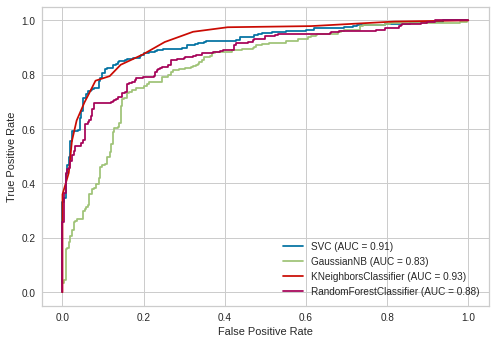

In [140]:
#@title ##### Specificity VS Sensibility- ORB


svc_plot = plot_roc_curve(SVM_Sift, X_test_Sift, y_test_Sift)
gnb_plot = plot_roc_curve(GNB_Sift, X_test_Sift, y_test_Sift, ax = ax, alpha = 1)
ax = plt.gca()

gnb_plot.plot(ax = ax, alpha = 1)

knn_plot = plot_roc_curve(KNN_Sift, X_test_Sift, y_test_Sift, ax = ax)

randomforest_plot = plot_roc_curve(RF_Sift, X_test_Sift, y_test_Sift, ax = ax, alpha = 1)

En general, podemos darnos cuenta que el **accuracy** tanto en SIFT como en SURF no sobrepasan el 50% como media.

En el caso de SURF el mejor modelo respecto al accuracy es el Support Vector Machine con una media del 48%, superior a cualquier otro modelo.

Para SIFT, el modelo que obtuvo un mejor desempeño respecto al accuracy es el Random Forest, el cual obtiene un 46%.

#**Aprendizaje no supervisado**

## Clusters Jerarquicos

###SURF

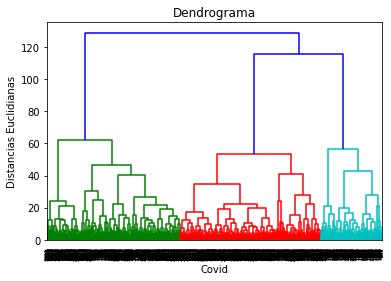

In [65]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X_Surf_PCA, method='ward'))
plt.title('Dendrograma')
plt.xlabel('Covid')
plt.ylabel('Distancias Euclidianas')
plt.show()

In [66]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(affinity='euclidean', linkage='ward')

XF = X_Surf_PCA.iloc[:, [0, 1]].values
y_hc = hc.fit_predict(XF)

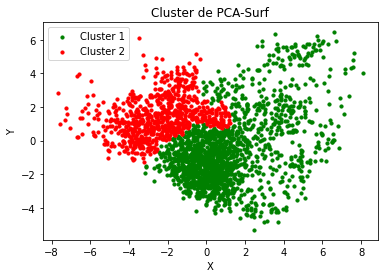

In [79]:
plt.scatter(XF[y_hc == 0, 0], XF[y_hc == 0, 1], s = 10, c = 'green', label = 'Cluster 1')
plt.scatter(XF[y_hc == 1, 0], XF[y_hc == 1, 1], s = 10, c = 'red', label = 'Cluster 2')

plt.title('Cluster de PCA-Surf')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

###SIFT

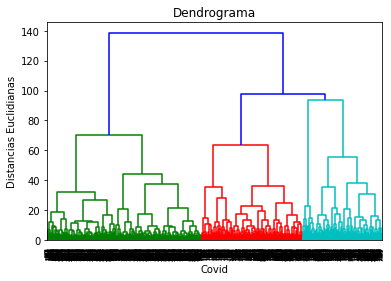

In [80]:
dendrogram = sch.dendrogram(sch.linkage(X_Sift_PCA, method='ward'))
plt.title('Dendrograma')
plt.xlabel('Covid')
plt.ylabel('Distancias Euclidianas')
plt.show()

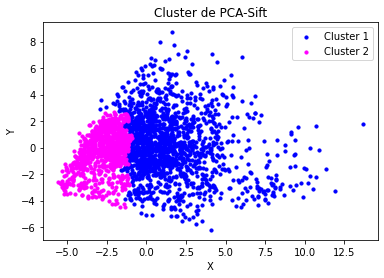

In [86]:
hc = AgglomerativeClustering(affinity='euclidean', linkage='ward')

XS = X_Sift_PCA.iloc[:, [0, 1]].values
y_hc = hc.fit_predict(XS)

plt.scatter(XS[y_hc == 0, 0], XS[y_hc == 0, 1], s = 10, c = 'blue', label = 'Cluster 1')
plt.scatter(XS[y_hc == 1, 0], XS[y_hc == 1, 1], s = 10, c = 'magenta', label = 'Cluster 2')

plt.title('Cluster de PCA-Sift')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

###ORB

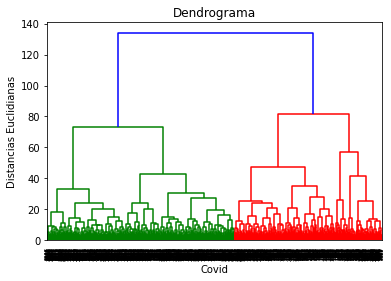

In [82]:
dendrogram = sch.dendrogram(sch.linkage(X_Orb_PCA, method='ward'))
plt.title('Dendrograma')
plt.xlabel('Covid')
plt.ylabel('Distancias Euclidianas')
plt.show()

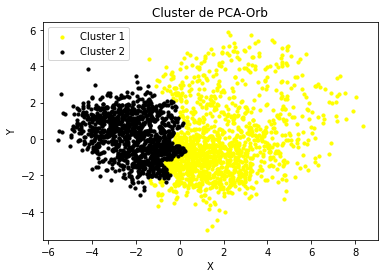

In [89]:
hc = AgglomerativeClustering(affinity='euclidean', linkage='ward')

XO = X_Orb_PCA.iloc[:, [0, 1]].values
y_hc = hc.fit_predict(XO)

plt.scatter(XO[y_hc == 0, 0], XO[y_hc == 0, 1], s = 10, c = 'yellow', label = 'Cluster 1')
plt.scatter(XO[y_hc == 1, 0], XO[y_hc == 1, 1], s = 10, c = 'black', label = 'Cluster 2')

plt.title('Cluster de PCA-Orb')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [72]:
!pip install minisom

  Created wheel for minisom: filename=MiniSom-2.2.7-cp36-none-any.whl size=8607 sha256=5ebfce105c74ea0e5a01d3fbd947ff383e39e3c02374dfb7857eff02ff3a6e5d
  Stored in directory: /root/.cache/pip/wheels/db/9a/af/0fca4ced67fec66c00998c4bf55b13f0a4c882ee775f278862
Successfully built minisom


##**MINISOM**

##SIFT

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 4.004659964981997


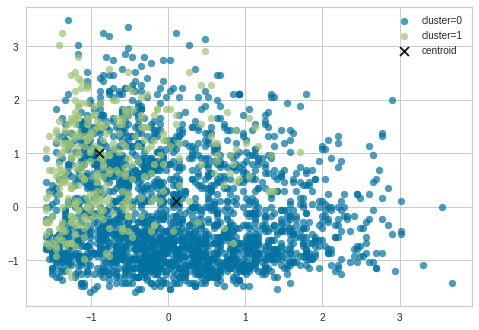

In [142]:
from minisom import MiniSom


df_sift_som = df_sift.iloc[:, :20]

df_sift_som = (df_sift_som - np.mean(df_sift_som, axis=0)) / np.std(df_sift_som, axis=0)
df_sift_som = df_sift_som.values

som_shape = (1, 2)
som = MiniSom(som_shape[0], som_shape[1], df_sift_som.shape[1], sigma=.5, learning_rate=.5, neighborhood_function='gaussian', random_seed=10)

som.train_batch(df_sift_som, 500, verbose=True)

winner_coordinates = np.array([som.winner(x) for x in df_sift_som]).T

cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

for c in np.unique(cluster_index):
    plt.scatter(df_sift_som[cluster_index == c, 0],
                df_sift_som[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)


for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=80, linewidths=35, color='k', label='centroid')
plt.legend();

###SURF

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 4.160927053071398


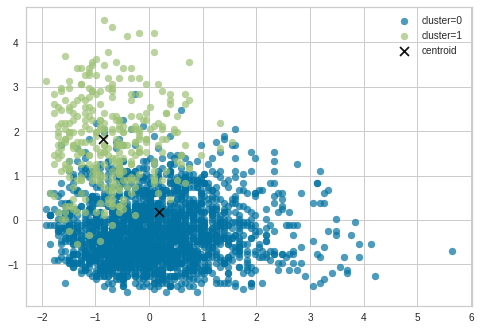

In [143]:
df_surf_som = df_surf.iloc[:, :20]

df_surf_som = (df_surf_som - np.mean(df_surf_som, axis=0)) / np.std(df_surf_som, axis=0)
df_surf_som = df_surf_som.values

som_shape = (1, 2)
som = MiniSom(som_shape[0], som_shape[1], df_surf_som.shape[1], sigma=.5, learning_rate=.5, neighborhood_function='gaussian', random_seed=10)

som.train_batch(df_surf_som, 500, verbose=True)

winner_coordinates = np.array([som.winner(x) for x in df_surf_som]).T

cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

for c in np.unique(cluster_index):
    plt.scatter(df_surf_som[cluster_index == c, 0],
                df_surf_som[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)


for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=80, linewidths=35, color='k', label='centroid')
plt.legend();

###ORB

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 4.086887111087319


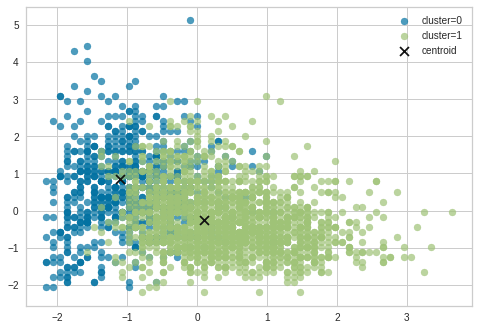

In [144]:
df_orb_som = df_orb.iloc[:, :20]

df_orb_som = (df_orb_som - np.mean(df_orb_som, axis=0)) / np.std(df_orb_som, axis=0)
df_orb_som = df_orb_som.values

som_shape = (1, 2)
som = MiniSom(som_shape[0], som_shape[1], df_orb_som.shape[1], sigma=.5, learning_rate=.5, neighborhood_function='gaussian', random_seed=10)

som.train_batch(df_orb_som, 500, verbose=True)

winner_coordinates = np.array([som.winner(x) for x in df_orb_som]).T

cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

for c in np.unique(cluster_index):
    plt.scatter(df_orb_som[cluster_index == c, 0],
                df_orb_som[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)


for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=80, linewidths=35, color='k', label='centroid')
plt.legend();